## Cookie Cats: A/B Testing Case Study

![](https://i.ytimg.com/vi/LkvnfULq8yQ/maxresdefault.jpg)

**Background**

[Cookie Cats](https://www.facebook.com/cookiecatsgame) is a hugely popular mobile puzzle game developed by [Tactile Entertainment](http://tactile.dk). It's a classic "connect three" style puzzle game where the player must connect tiles of the same color in order to clear the board and win the level. It also features singing cats. We're not kidding!

As players progress through the levels of the game, they will occasionally encounter gates that force them to wait a non-trivial amount of time or make an in-app purchase to progress. In addition to driving in-app purchases, these gates serve the important purpose of giving players an enforced break from playing the game, hopefully resulting in that the player's enjoyment of the game being increased and prolonged.

But where should the gates be placed? Initially the first gate was placed at level 30, but what would happen if we moved the first gate in Cookie Cats from level 30 to level 40. In particular, we will look at the impact on player retention.

*Reference: [Datacamp projects](https://www.datacamp.com/projects/184)*

**Acknowledgements**

The data is taken from Kaggle Datasets: [Cookie Cats](https://www.kaggle.com/mursideyarkin/mobile-games-ab-testing-cookie-cats). The data we have is from 90,189 players that installed the game while the AB-test was running. Note that when a player installed the game, the player was randomly assigned to either.

**Data Description**

| Column         | Description                                                                                                                          | Values             |
|----------------|--------------------------------------------------------------------------------------------------------------------------------------|--------------------|
| userid         | a unique number that identifies each player                                                                                          | Unique Identifier  |
| version        | whether the player was put in the control group ( gate_30  - a gate at level 30) or the test group ( gate_40  - a gate at level 40). | [gate_30, gate_40] |
| sum_gamerounds | number of game rounds played during the first week after installation                                                                | Numerical Values   |
| retention_1    | whether the player come back and play 1 day after installing                                                                         | [TRUE, FALSE]      |
| retention_7    | whether the player come back and play 7 days after installing                                                                        | [TRUE, FALSE]      |

### Import Libraries

In [1]:
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno

from scipy.stats import shapiro
import scipy.stats as stats

plt.style.use('fivethirtyeight')

### Import Dataset

Before we do any analysis, we will first take a look at the data using `pandas-profiling`. This will give us a quick overview of the data and give us a quick idea of the distribution of the data. The result of `pandas-profiling` is a nice looking report in `.html`.

In [4]:
df = pd.read_csv('cookie_cats.csv')
df

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True
...,...,...,...,...,...
90184,9999441,gate_40,97,True,False
90185,9999479,gate_40,30,False,False
90186,9999710,gate_30,28,True,False
90187,9999768,gate_40,51,True,False


From the report, we can conclude that:

- `userid` has unique values.
- `gate_30` and `gate_40` are the only two groups and the number of users that are in each group is equal.
- `sum_gamerounds` has 3994 zeros meaning that 4.4% of the users did not even play the game. It is also highly skewed with one of the player having played for over 45,000 rounds.
- Both `retention_1` and `retention_7` are highly correlated with `sum_gamerounds`.
- There are no missing values.

In [6]:
df['userid'] = df['userid'].astype('category')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   userid          90189 non-null  category
 1   version         90189 non-null  object  
 2   sum_gamerounds  90189 non-null  int64   
 3   retention_1     90189 non-null  bool    
 4   retention_7     90189 non-null  bool    
dtypes: bool(2), category(1), int64(1), object(1)
memory usage: 4.6+ MB


### Summary Stats

Now, we will try to compare the two groups and see if there is any difference in `sum_gamerounds`.

In [10]:
def two_version_comparison(df, version, treatment_val, control_val, metric, skewed=False):
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))
    df[(df[version] == control_val)].hist(metric, ax=axes[0])
    df[(df[version] == treatment_val)].hist(metric, ax=axes[1])
    sns.boxplot(x=version, y=metric, data=df, ax=axes[2])
    
    axes[0].set_title('Distribution of {}'.format(control_val))
    axes[1].set_title('Distribution of {}'.format(treatment_val))
    axes[2].set_title('Distribution of Two Groups')


From the result below, we can see that the mean and median of the two groups are very close although the standard deviation is quite different.

In [12]:
df.groupby('version')['sum_gamerounds'].agg(['count', 'mean', 'median', 'std', 'min', 'max'])

,count,mean,median,std,min,max
version,,,,,,
gate_30,44700,52.456264,17.0,256.716423,0,49854
gate_40,45489,51.298776,16.0,103.294416,0,2640


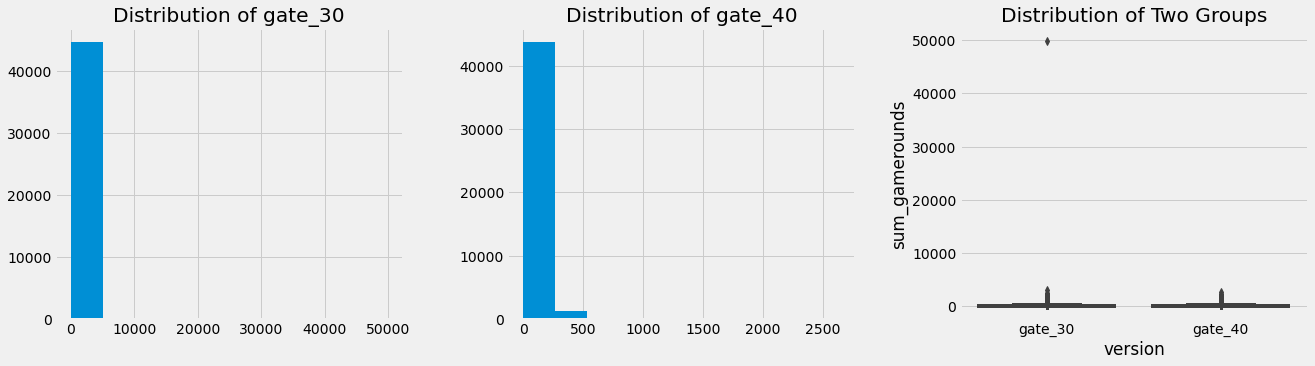

In [13]:
two_version_comparison(df, 'version', 'gate_40', 'gate_30', 'sum_gamerounds')

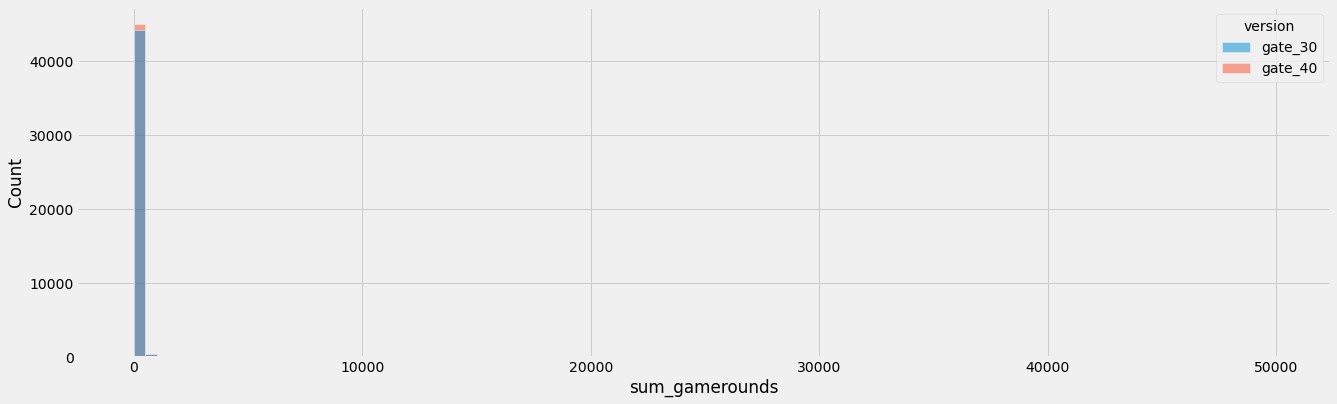

In [14]:
plt.figure(figsize=(20, 6))
sns.histplot(x='sum_gamerounds', data=df, hue='version', bins=100)
plt.show()

Now, we will drop the row where the `sum_gamerounds` is 49854 because we conclude that it is nearly impossible for a player to play the game that much and if it is in fact possible, it is only one row and won't affect the result.

In [15]:
df[df['sum_gamerounds'] > df['sum_gamerounds'].quantile(0.9999)]

,userid,version,sum_gamerounds,retention_1,retention_7
6536,725080,gate_40,2015,True,True
7912,871500,gate_30,2961,True,True
29417,3271615,gate_40,2640,True,False
36933,4090246,gate_40,2124,True,True
43671,4832608,gate_30,2438,True,True
46344,5133952,gate_30,2251,True,True
48188,5346171,gate_40,2294,True,True
57702,6390605,gate_30,49854,False,True
87007,9640085,gate_30,2156,True,True
88328,9791599,gate_40,2063,True,True


In [16]:
df = df[df['sum_gamerounds'] < 3000]

Now, we will try to compare the versions again.

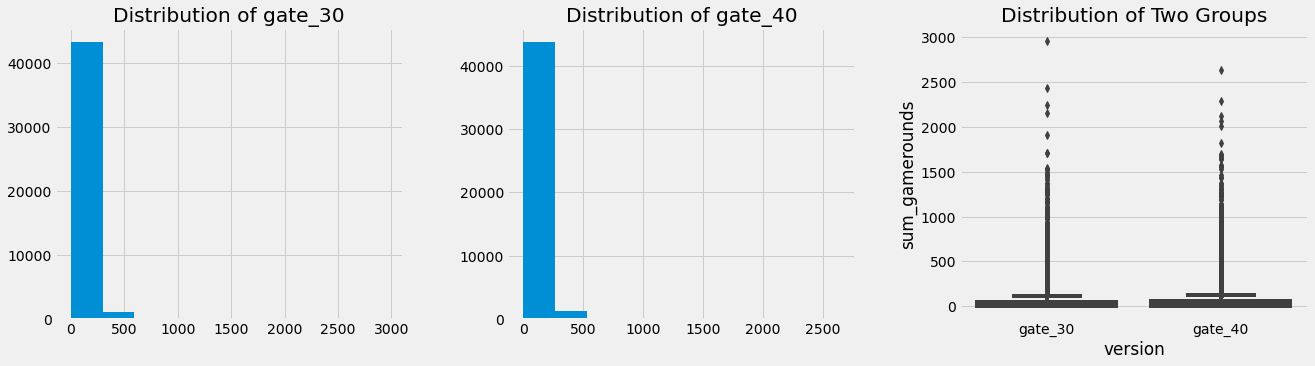

In [17]:
two_version_comparison(df, 'version', 'gate_40', 'gate_30', 'sum_gamerounds')

In [18]:
def plot_skewed(df, version, control_val, treatment_val, metric):
    df[df[version] == control_val].reset_index().set_index('index')[metric].plot(legend=True, label='Gate 30 (Control)', figsize = (20,5))
    df[df[version] == treatment_val].reset_index().set_index('index')[metric].plot(legend=True, label='Gate 40 (Treatment)', alpha=0.65)  

From the plot below, we can see there are no significant differences between the two versions in `sum_gamerounds`. We will validate this assumption using hypothesis testing.

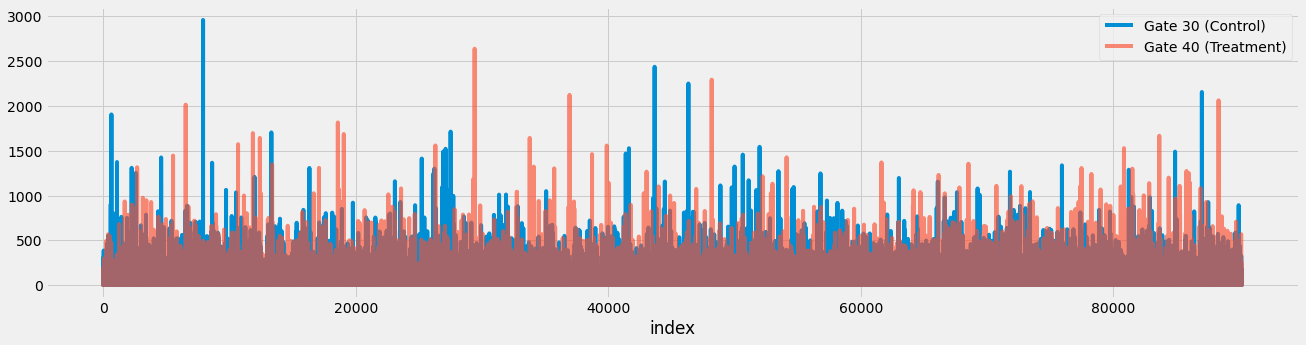

In [19]:
plot_skewed(df, 'version', 'gate_30', 'gate_40', 'sum_gamerounds')

But before that, let's take a look at the distribution of the data.

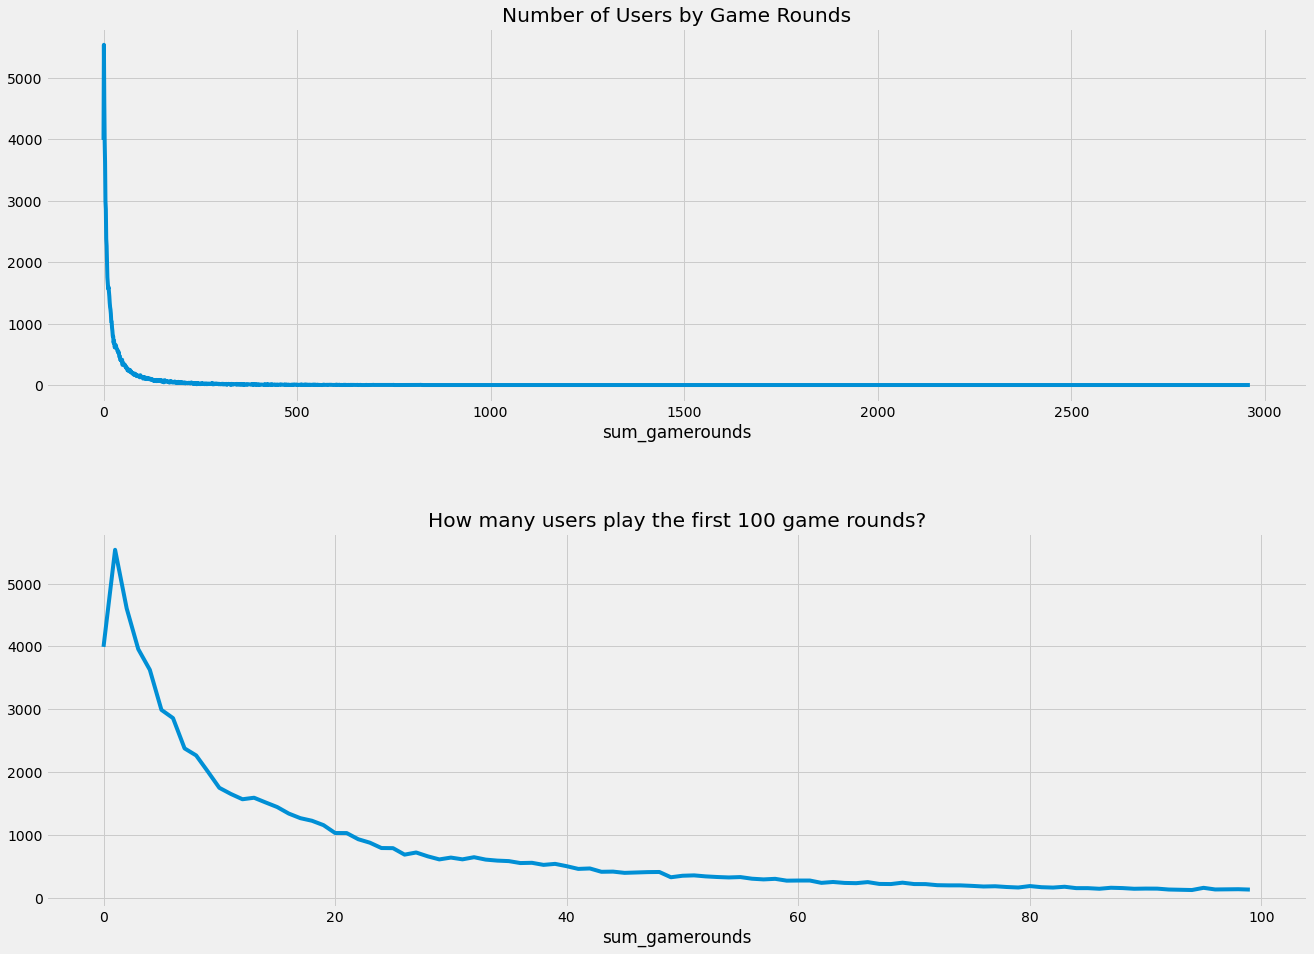

In [28]:
fig, axes = plt.subplots(2, 1, figsize = (20,15))
df.groupby('sum_gamerounds').userid.count().plot(ax = axes[0])
df.groupby('sum_gamerounds').userid.count()[:100].plot(ax = axes[1])
axes[0].set_title('Number of Users by Game Rounds')
axes[1].set_title('How many users play the first 100 game rounds?')
plt.tight_layout(pad=5)
plt.show()

We can also check how many users are currently stuck at gate 30 and gate 40.

<AxesSubplot:xlabel='sum_gamerounds'>

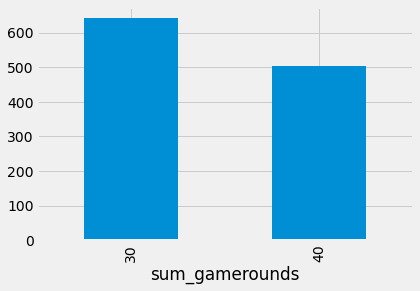

In [31]:
df.groupby('sum_gamerounds').userid.count().loc[[30, 40]].plot(kind='bar')

### A/B Testing

In [32]:
def ab_test(df, group, target):
    # Split A/B
    groupA = df[df[group] == 'A'][target]
    groupB = df[df[group] == 'B'][target]

    # Assumption: Normality of the data
    # H0: The distribution is normal (False)
    # H1: The distribution is not normal (True)
    
    if(groupA.shape[0] > 5000 and groupB.shape[0] > 5000):
        print("Performing D'Agostino's K2 test")
        statistics, pvalueA = stats.normaltest(groupA)
        statistics, pvalueB = stats.normaltest(groupB)
        ntA = pvalueA < 0.05 # reject H0
        ntB = pvalueB < 0.05 # reject H0
        print('The distribution of {} is normal: {}'.format(groupA.name, ntA))
        print('The distribution of {} is normal: {}'.format(groupB.name, ntB))  
    else:   
        ntA = shapiro(groupA)[1] < 0.05
        ntB = shapiro(groupB)[1] < 0.05
        print('The distribution of {} is normal: {}'.format(groupA.name, ntA))
        print('The distribution of {} is normal: {}'.format(groupB.name, ntB))   
    
    # If the data has normal distribution
    if ntA == False and ntB == False: 
        # Parametric test
        # Assumption: Homogeneity of variance
        # H0: Homogeneity of variance (False)
        # H1: Heterogeneity of variance (True)
        levene_result = stats.levene(groupA, groupB)[1] < 0.05
        
        # If the data has homogeneity of variance
        if levene_result == False:
            ttest = stats.ttest_ind(groupA, groupB, equal_var=True)[1]
            # H0: The two groups are not significantly different (False)
            # H1: The two groups are significantly different (True)
            
        else:
            ttest = stats.ttest_ind(groupA, groupB, equal_var=False)[1]
            # H0: The two groups are not significantly different (False)
            # H1: The two groups are significantly different (True)
            
    else:
        # Non-parametric test
        ttest = stats.mannwhitneyu(groupA, groupB)[1]
        # H0: The two groups are not significantly different (False)
        # H1: The two groups are significantly different (True)      
        
    # Hypothesis
    test_type = 'parametric' if ntA == False and ntB == False else 'non-parametric'
    result = 'Reject H0' if ttest < 0.05 else 'Fail to reject H0'
    
    print('H0: The two groups are not significantly different')
    print('H1: The two groups are significantly different')  
    print('P-value: {}'.format(ttest))
    print('Test type: {}'.format(test_type))
    print('Test result: {}'.format(result))

In [33]:
df['version'] = np.where(df['version'] == 'gate_30', 'A', 'B')
df['version'].value_counts()

/var/folders/8y/8kswtck15wb0z0qbbln6nqgr0000gn/T/ipykernel_68216/2830859711.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['version'] = np.where(df['version'] == 'gate_30', 'A', 'B')


B    45489
A    44699
Name: version, dtype: int64

In [34]:
ab_test(df=df, group='version', target='sum_gamerounds')

Performing D'Agostino's K2 test
The distribution of sum_gamerounds is normal: True
The distribution of sum_gamerounds is normal: True
H0: The two groups are not significantly different
H1: The two groups are significantly different
P-value: 0.05089155279145376
Test type: non-parametric
Test result: Fail to reject H0


From the result above, we can conclude that version doesn't have any significant difference in `sum_gamerounds`.

### Bootstrap

In [53]:
def bootstrap_testing(df, group, metric, rounds=1000):
    bootstrap_result = []
    
    for _ in range(rounds):
        boostrap_mean = df.sample(frac=1, replace=True).groupby(group)[metric].mean()
        bootstrap_result.append(boostrap_mean)
        
    bootstrap_df = pd.DataFrame(bootstrap_result)
    
    # Plot the results
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(20,14))
    axes[0].set_title('Distribution of Bootstrap Samples')
    sns.kdeplot(data=bootstrap_df, shade=True, ax=axes[0])
    
    # Find % difference between the two AB-groups
    bootstrap_df['difference'] = (bootstrap_df['A'] - bootstrap_df['B']) / bootstrap_df['B'] * 100
    axes[1].set_title('% Difference between the two AB-groups')
    sns.kdeplot(data=bootstrap_df['difference'], ax=axes[1])
    plt.tight_layout(pad=5);
    
    return bootstrap_df

Probability that 1-day retention is greater when the gate is at level 30: 0.963


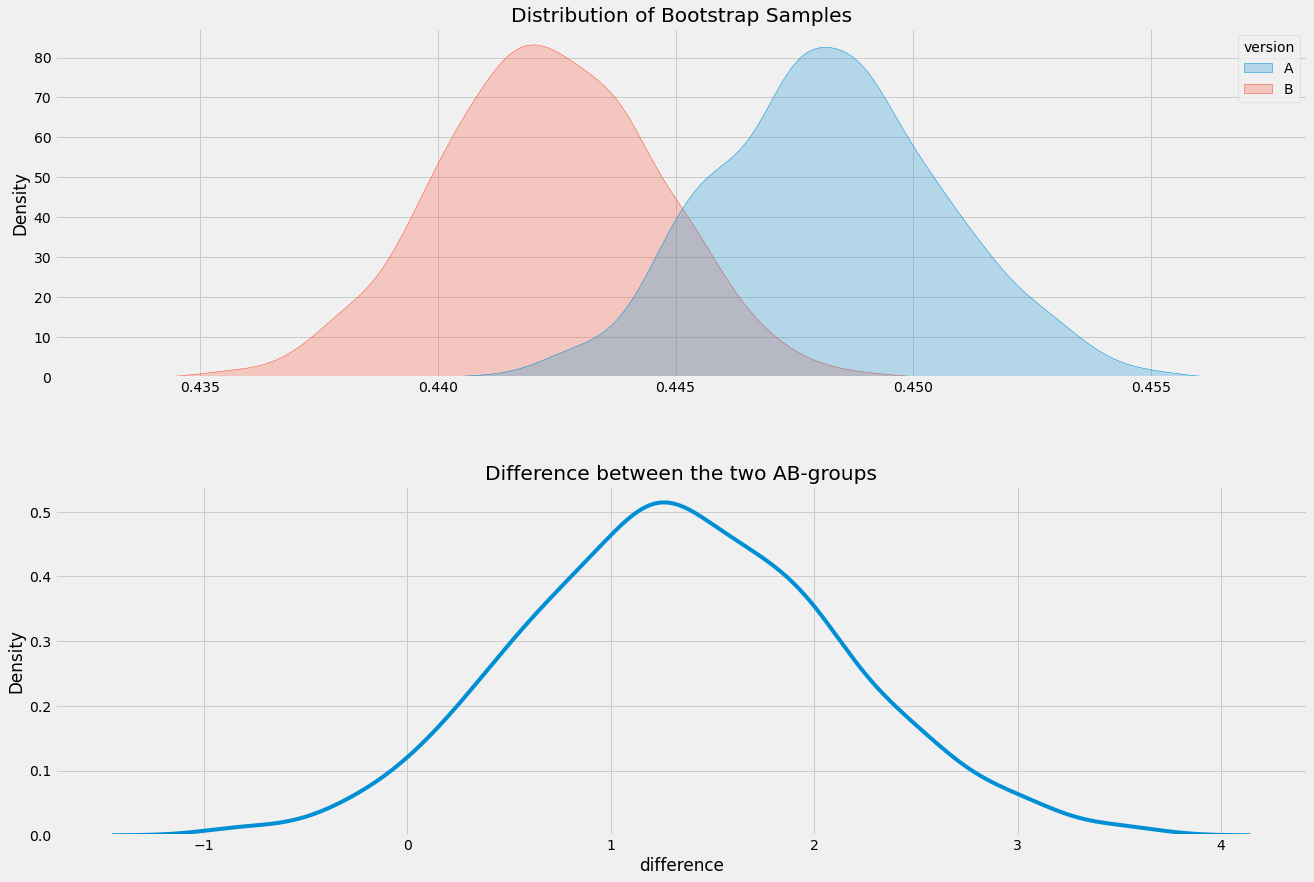

In [54]:
bootstrap_df = bootstrap_testing(df, 'version', 'retention_1')
print('Probability that 1-day retention is greater when the gate is at level 30:', (bootstrap_df['difference'] > 0).mean())

Probability that rounds played is greater when the gate is at level 30: 0.528


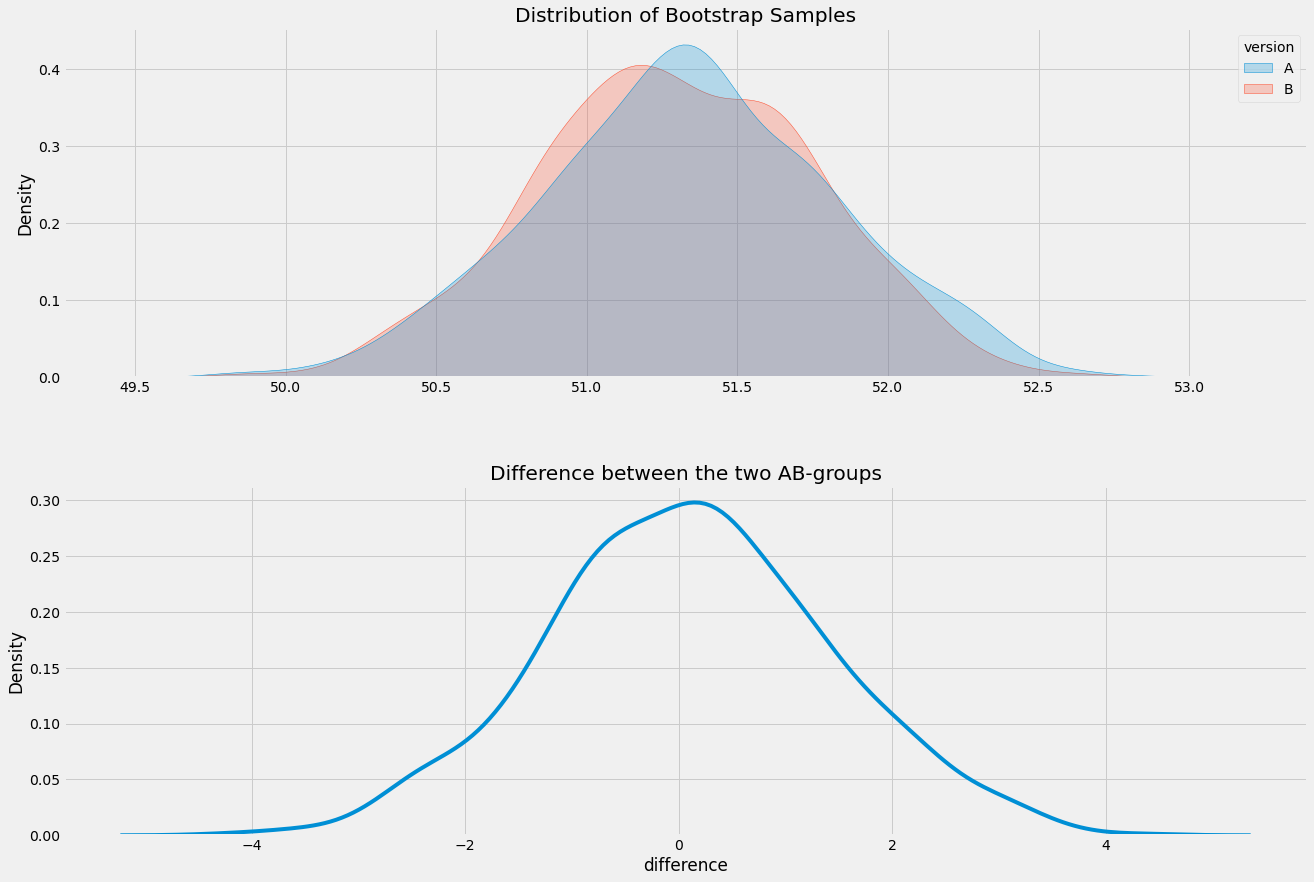

In [55]:
bootstrap_df = bootstrap_testing(df, 'version', 'sum_gamerounds')
print('Probability that rounds played is greater when the gate is at level 30:', (bootstrap_df['difference'] > 0).mean())

Probability that 7-day retention is greater when the gate is at level 30: 1.0


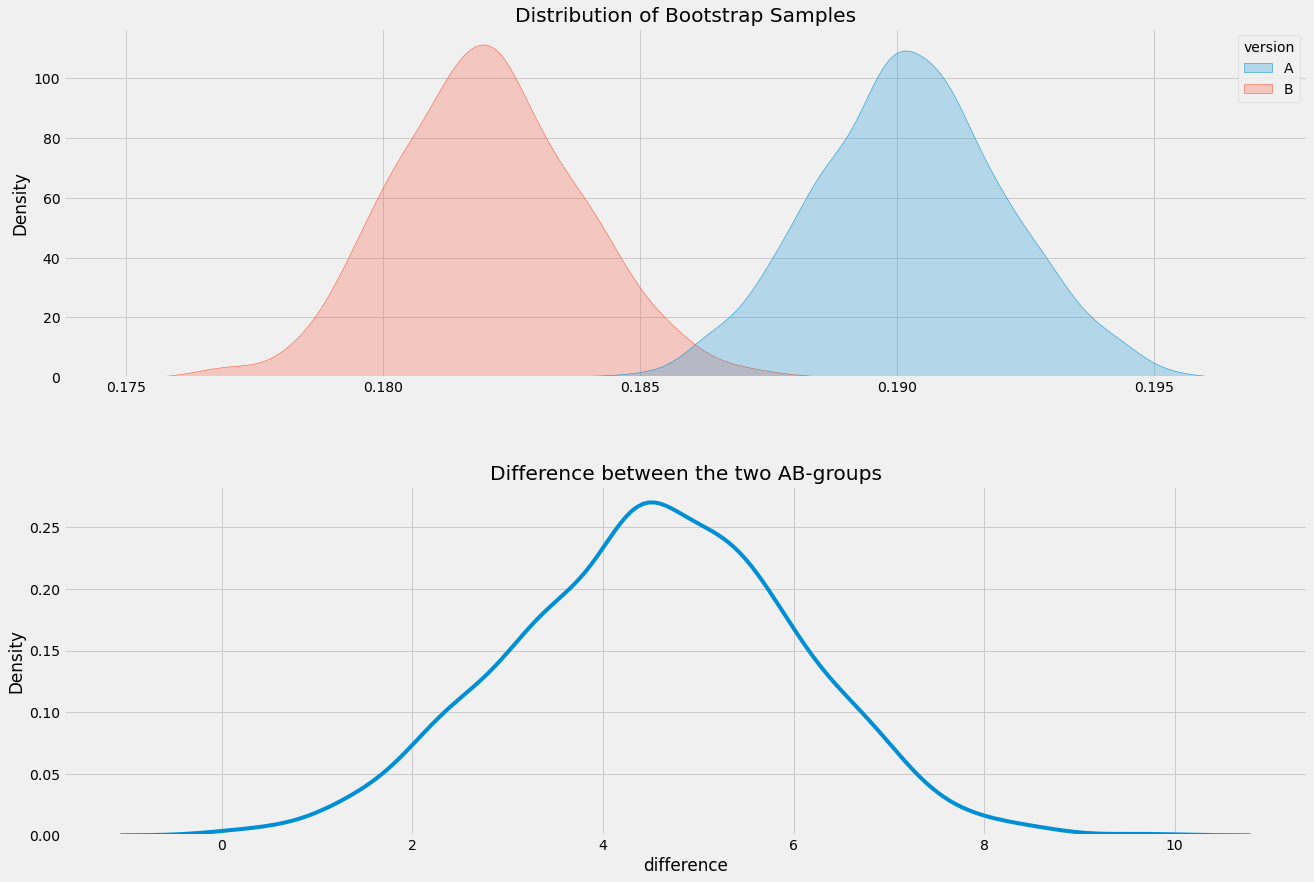

In [56]:
bootstrap_df = bootstrap_testing(df, 'version', 'retention_7')
print('Probability that 7-day retention is greater when the gate is at level 30:', (bootstrap_df['difference'] > 0).mean())